In [1]:
# Data Array Imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Math
import math

# Plot imports
%matplotlib inline
import matplotlib.pyplot as plt
from ggplot import *
#import seaborn as sns
#sns.set_style('whitegrid')

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

# For evaluating our ML results
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve

# season DataFrame is simply the regular/real seaon connected to the post/play off data
real_season = pd.read_csv('passes.csv')
season = pd.read_csv('combined.csv')
post_season = pd.read_csv('passes_post.csv')


# The average is found to convert from integer to decimals since logistic regression requires continuity.
def find_avg(x):
    return x/16.0

In [2]:
season.head()

,Down,Yards,QB,QB Sacks,QB Years,QB Height,QB Weight,QB Fumbles,QB Rush Att,QB Passer Rating,Receiver ID,Receiver Pos,Receiver Years,Receiver Height,Receiver Weight,Team,Intercepted,Success
0,1,10,B.Roethlisberger,33,12,77,240,2,15,94.4,34,WR,6,70,181,PIT,0,1
1,1,10,B.Roethlisberger,33,12,77,240,2,15,94.4,33,TE,11,77,256,PIT,0,1
2,3,22,B.Roethlisberger,33,12,77,240,2,15,94.4,33,TE,11,77,256,PIT,0,1
3,1,10,T.Brady,38,16,76,225,6,34,103.8,2,WR,7,70,200,NE,0,1
4,1,10,T.Brady,38,16,76,225,6,34,103.8,1,RB,4,68,195,NE,0,1


In [3]:
# Dummy variables to remove collinearity, e.g. If a variable can be one of 3 (WR, RB, TE), if it is neither RB or TE, 
# it can only be WR so we can aurgue they are correlated
receiver_pos_dummies = pd.get_dummies(season['Receiver Pos'])
down_dummies = pd.get_dummies(season['Down'])
down_dummies.columns = ['Down 1', 'Down 2', 'Down 3', 'Down 4']
#team_dummies = pd.get_dummies(season['Team'])
#receiver_id_dummies = pd.get_dummies(season['Receiver ID'])
#qb_dummies = pd.get_dummies(season['QB'])

In [4]:
season.head()

,Down,Yards,QB,QB Sacks,QB Years,QB Height,QB Weight,QB Fumbles,QB Rush Att,QB Passer Rating,Receiver ID,Receiver Pos,Receiver Years,Receiver Height,Receiver Weight,Team,Intercepted,Success
0,1,10,B.Roethlisberger,33,12,77,240,2,15,94.4,34,WR,6,70,181,PIT,0,1
1,1,10,B.Roethlisberger,33,12,77,240,2,15,94.4,33,TE,11,77,256,PIT,0,1
2,3,22,B.Roethlisberger,33,12,77,240,2,15,94.4,33,TE,11,77,256,PIT,0,1
3,1,10,T.Brady,38,16,76,225,6,34,103.8,2,WR,7,70,200,NE,0,1
4,1,10,T.Brady,38,16,76,225,6,34,103.8,1,RB,4,68,195,NE,0,1


In [5]:
# Prepare the dataframe
training_data = season.drop(['Receiver Pos', 'Down', 'Team', 'Intercepted', 'Success','Receiver ID', 'QB', 'Intercepted'], axis=1)
#dummies = pd.concat([qb_dummies, receiver_pos_dummies, receiver_id_dummies, down_dummies, team_dummies], axis=1)
dummies = pd.concat([receiver_pos_dummies, down_dummies], axis=1)
training_data = pd.concat([training_data, dummies], axis=1)

# Apply avg and drop columns
training_data['QB Sacks'] = training_data['QB Sacks'].apply(find_avg)
training_data['QB Fumbles'] = training_data['QB Fumbles'].apply(find_avg)
training_data['QB Rush Att'] = training_data['QB Rush Att'].apply(find_avg)

# Remove columns to get rid of collinearity
#training_data = training_data.drop(['B.Roethlisberger','RB', 1, 'Down 4', 'PIT'], axis=1)
training_data = training_data.drop(['RB', 'Down 4'], axis=1)

# Season succesful passes
Y_season = season['Success']

'''Reg season length 0 - 17821'''

Y = np.ravel(Y_season)

In [6]:
#Logtistic Model

log_model = LogisticRegression()
log_model.fit(training_data, Y)

# Model accuracy based on all of the data
print 'Model Logistic'
print log_model.score(training_data, Y)

#Null Error Rate
print 1 - Y.mean()
print '\n'

coeff_df = DataFrame(zip(training_data.columns, np.transpose(log_model.coef_)))
coeff_df.to_csv('result1.csv')

Model Logistic
0.619900497512
0.380873410724




In [7]:
'''Model Naive Bayes'''
gnb = GaussianNB()
gnb.fit(training_data, Y)

# Model accuracy based on all of the data
print 'Model Naive Bayes'
print gnb.score(training_data, Y)

#Null Error Rate
print 1 - Y.mean()
print '\n'

Model Naive Bayes
0.611608623549
0.380873410724




In [8]:
'''Model Decision Tree'''
clf = tree.DecisionTreeClassifier()
clf.fit(training_data, Y)

# Model accuracy based on all of the data
print 'Model Decision Tree'
print clf.score(training_data, Y)

#Null Error Rate
print 1 - Y.mean()
print '\n'

Model Decision Tree
0.785406301824
0.380873410724




In [9]:
#Split the dataset into regular and post season data
X_train = training_data[:17822]
X_test = training_data[17822:]

y_train = np.ravel(Y_season[:17822])
y_test = np.ravel(Y_season[17822:])

In [10]:
log_model2 = LogisticRegression()
log_model2.fit(X_train, y_train)
class_predict = log_model2.predict(X_test)

preds = log_model2.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Logistic Model - with split'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Coeff and the impactfulness on the model
coeff_df = DataFrame(zip(X_train.columns, np.transpose(log_model2.coef_)))
coeff_df.to_csv('result2.csv')

# Compute confusion matrix
#cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

#cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Logistic Model - with split
0.563432835821
0.429104477612


Confusion matrix, without normalization
Predicted  0    1  All
Actual                
0          1  114  115
1          3  150  153
All        4  264  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.004348  0.372549  0.214552
1          0.013043  0.490196  0.285448
All        0.017391  0.862745  0.500000


In [11]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)

C:\Users\Oliver\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


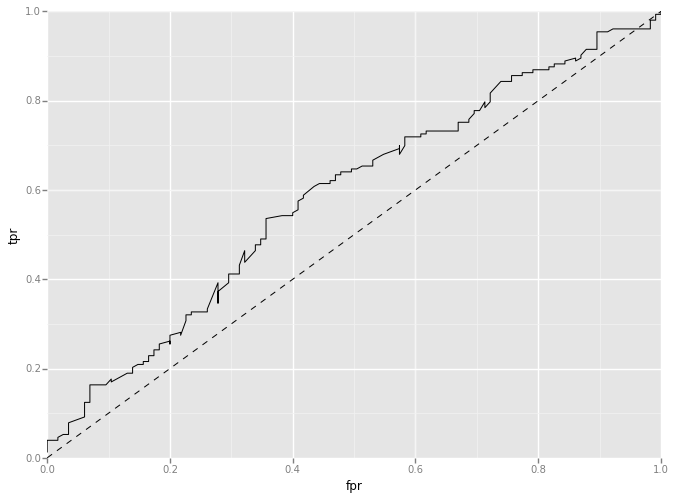

<ggplot: (33700310)>

In [12]:
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

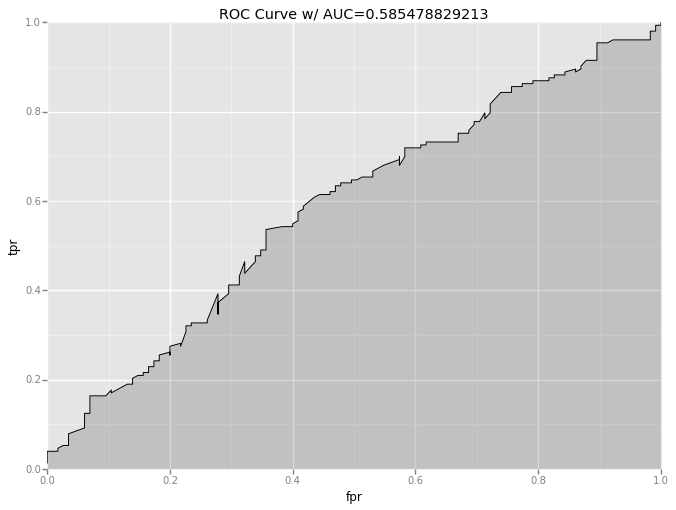

<ggplot: (36172706)>

In [13]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [14]:
log_model3 = LogisticRegression(penalty='l1')
log_model3.fit(X_train, y_train)
class_predict = log_model3.predict(X_test)

preds = log_model3.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Logistic Model - with split and l1 penalty'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Coeff and the impactfulness on the model
coeff_df = DataFrame(zip(X_train.columns, np.transpose(log_model3.coef_)))
coeff_df.to_csv('result3.csv')

# Compute confusion matrix
cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Logistic Model - with split and l1 penalty
0.563432835821
0.429104477612


Confusion matrix, without normalization
Predicted  0    1  All
Actual                
0          1  114  115
1          3  150  153
All        4  264  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.004348  0.372549  0.214552
1          0.013043  0.490196  0.285448
All        0.017391  0.862745  0.500000


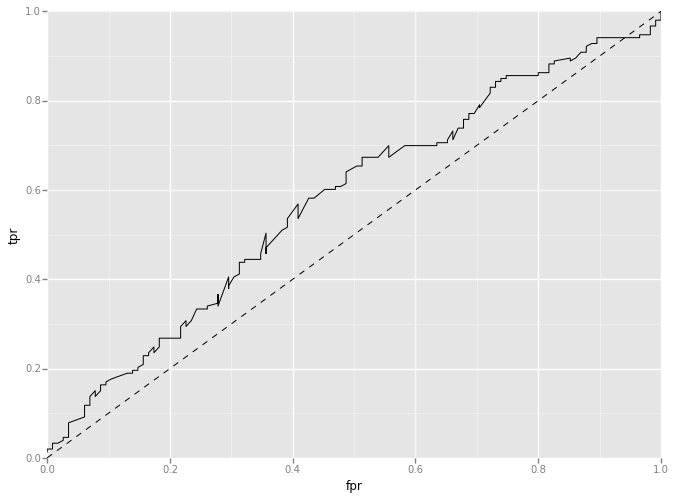

<ggplot: (33786744)>

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

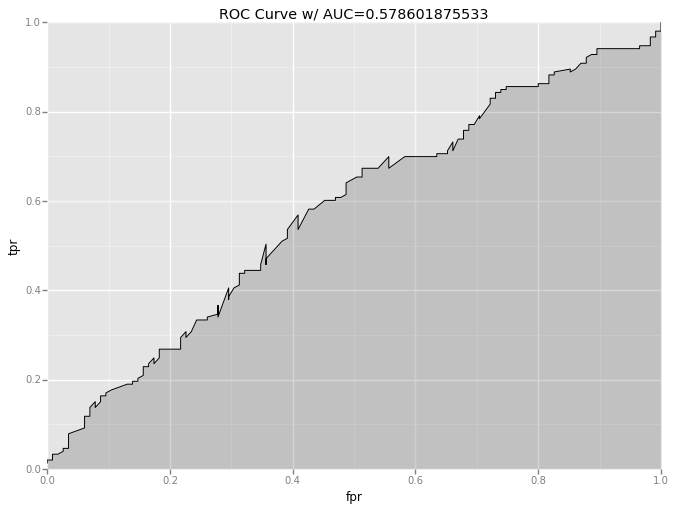

<ggplot: (33782392)>

In [16]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [17]:
'''Decision Tree'''

model4 = tree.DecisionTreeClassifier()
model4.fit(X_train, y_train)
class_predict = model4.predict(X_test)
preds = model4.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Decision Tree Model - with split'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Compute confusion matrix
#cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

#cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Decision Tree Model - with split
0.582089552239
0.429104477612


Confusion matrix, without normalization
Predicted   0    1  All
Actual                 
0          40   75  115
1          37  116  153
All        77  191  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.173913  0.245098  0.214552
1          0.160870  0.379085  0.285448
All        0.334783  0.624183  0.500000


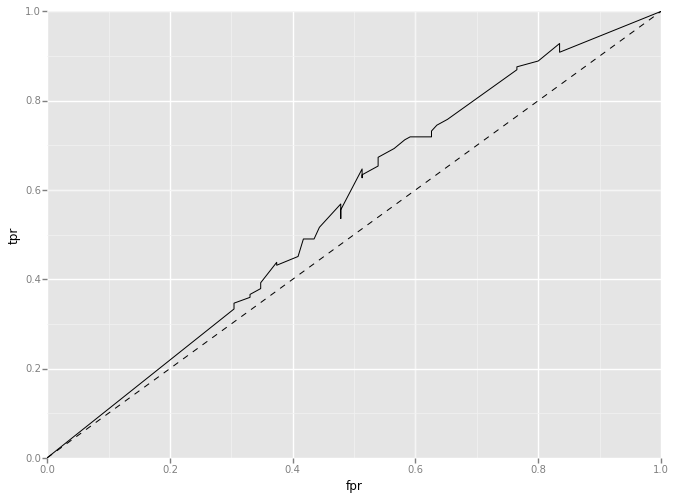

<ggplot: (36502592)>

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

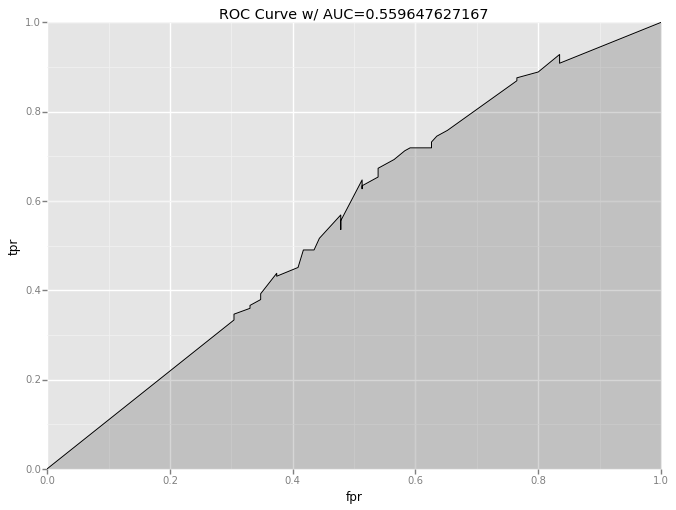

<ggplot: (36307842)>

In [19]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [20]:
'''Naive Bayes'''

model5 = GaussianNB()
model5.fit(X_train, y_train)
class_predict = model5.predict(X_test)
preds = model5.predict_proba(X_test)[:,1]

df_confusion = pd.crosstab(y_test, class_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

# Accuracy and null error rate
print 'Naive Bayes Model - with split'
print metrics.accuracy_score(y_test, class_predict)
print 1 - y_test.mean()
print '\n'

# Compute confusion matrix
#cm1 = confusion_matrix(y_test, class_predict)
print('Confusion matrix, without normalization')
print(df_confusion)
print '\n'

#cm2 = cm1 / cm1.astype(np.float).sum(axis=1)
np.set_printoptions(precision=2)
print('Confusion matrix, with normalization')
print(df_conf_norm)

Naive Bayes Model - with split
0.589552238806
0.429104477612


Confusion matrix, without normalization
Predicted   0    1  All
Actual                 
0          18   97  115
1          13  140  153
All        31  237  268


Confusion matrix, with normalization
Predicted         0         1       All
Actual                                 
0          0.078261  0.316993  0.214552
1          0.056522  0.457516  0.285448
All        0.134783  0.774510  0.500000


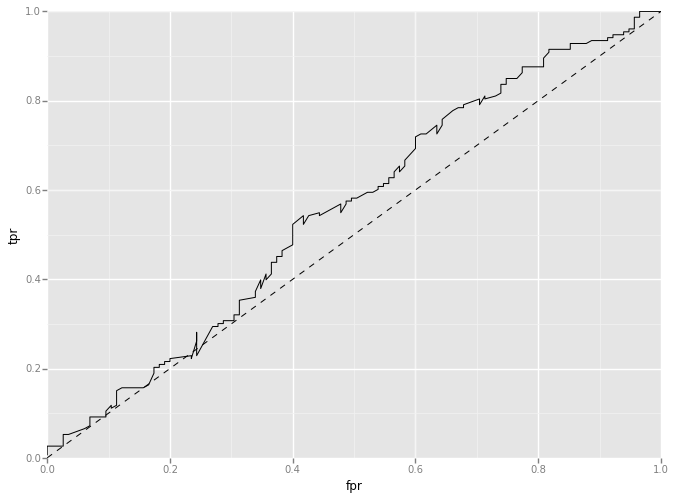

<ggplot: (36502581)>

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, preds)#, pos_label=2)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

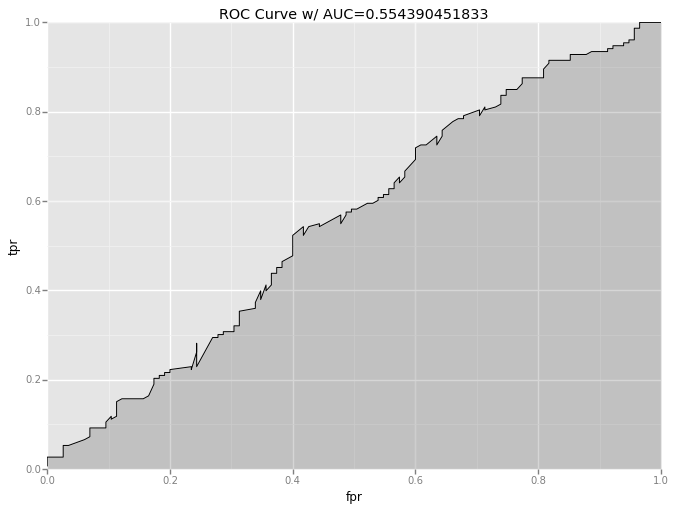

<ggplot: (36660070)>

In [22]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) + geom_area(alpha=0.2) + geom_line(aes(y='tpr')) + ggtitle("ROC Curve w/ AUC=%s" % str(auc))